<a href="https://colab.research.google.com/github/cristianmunoz1/Intro_ML_project/blob/main/Clasificaci%C3%B3n/06_SVM_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SVM (Máquina de vectores de soporte)

Importamos las librerías necesarias

In [ ]:
import pandas as pd
import numpy as np
from sklearn import svm
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Segunda parte
from sklearn.model_selection import GridSearchCV

Cargamos los datos preprocesados a un df

In [ ]:
df = pd.read_csv('data_class.csv')
X = df.drop(columns=["AdoptionLikelihood"])
y = df["AdoptionLikelihood"].astype(int)

Definimos la función para experimentar con diferentes hiperparámetros del SVM

In [ ]:
def experimentar_svc(X, y, kernels, Cs, gammas):
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    resultados = []

    for kernel in kernels:
        for C in Cs:
            for gamma in gammas:
                accs, precs, recalls, aucs = [], [], [], []
                for train_idx, test_idx in skf.split(X, y):
                    X_train, X_test = X[train_idx], X[test_idx]
                    y_train, y_test = y[train_idx], y[test_idx]

                    modelo = svm.SVC(
                        kernel=kernel,
                        C=C,
                        gamma=gamma,
                        probability=True,
                        random_state=42
                    )

                    modelo.fit(X_train, y_train)
                    y_pred = modelo.predict(X_test)
                    y_proba = modelo.predict_proba(X_test)[:, 1]

                    precs.append(precision_score(y_test, y_pred, zero_division=0))
                    recalls.append(recall_score(y_test, y_pred))
                    aucs.append(roc_auc_score(y_test, y_proba))

                resultados.append({
                    "kernel": kernel,
                    "C": C,
                    "gamma": gamma,
                    "Precision": np.mean(precs),
                    "Recall": np.mean(recalls),
                    "ROC AUC": np.mean(aucs)
                })

    return pd.DataFrame(resultados)

In [ ]:
kernels = ['linear', 'rbf']
Cs = [0.1, 1.0, 10.0, 100.0]
gammas = [0.001, 0.01, 0.1, 'scale']

In [ ]:
resultados_svc = experimentar_svc(X.to_numpy(), y.values, kernels, Cs, gammas)
mejores = resultados_svc.sort_values(by="ROC AUC", ascending=False)
print("Mejores hiperparámetros:")
display(mejores.head(5))

Mejores hiperparámetros:


,kernel,C,gamma,Precision,Recall,ROC AUC
12,linear,100.0,0.001,0.661068,0.537167,0.807605
13,linear,100.0,0.01,0.661068,0.537167,0.807605
14,linear,100.0,0.1,0.661068,0.537167,0.807605
15,linear,100.0,scale,0.661068,0.537167,0.807605
8,linear,10.0,0.001,0.661615,0.535652,0.807321


In [ ]:
mejor = mejores.iloc[0]
print(mejor)
svc_final = svm.SVC(
    kernel=mejor['kernel'],
    C=mejor['C'],
    gamma=mejor['gamma'],
    probability=True,
    random_state=42
)

kernel         linear
C               100.0
gamma           0.001
Precision    0.661068
Recall       0.537167
ROC AUC      0.807605
Name: 12, dtype: object


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y.values, test_size=0.2, stratify=y.values, random_state=42
)

In [ ]:
svc_final.fit(X_train, y_train)
y_pred = svc_final.predict(X_test)
y_proba = svc_final.predict_proba(X_test)[:, 1]

In [ ]:
print("\n=== Métricas en el conjunto de prueba ===")
print(f"Precisión: {precision_score(y_test, y_pred):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred):.3f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.3f}")


=== Métricas en el conjunto de prueba ===
Precisión: 0.660
Recall:    0.530
ROC AUC:   0.781


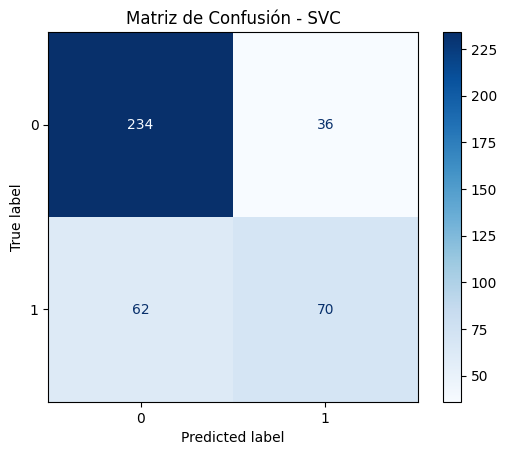

In [ ]:
ConfusionMatrixDisplay.from_estimator(svc_final, X_test, y_test, cmap='Blues')
plt.title("Matriz de Confusión - SVC")
plt.show()

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

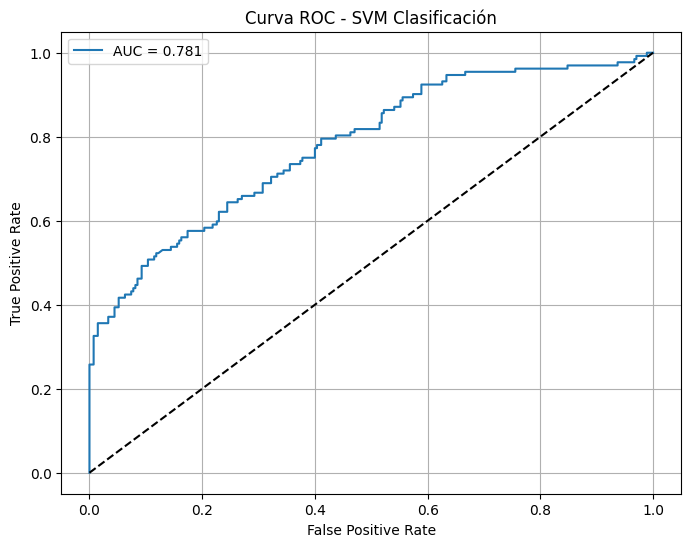

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - SVM Clasificación')
plt.legend()
plt.grid()
plt.show()

## Segunda parte

Instanciamos el modelo base

In [ ]:
svc = svm.SVC()

Definimos la malla de parámetros

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto'],
    'degree': [2, 3],
    'class_weight': [None, 'balanced'],
    'max_iter': [-1],
}


Usamos cross-validation estratificada

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Instanciamos el objeto de gridsearchcv

In [ ]:
grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=cv,
    scoring={'precision': 'precision', 'recall': 'recall', 'roc_auc': 'roc_auc'},
    refit = 'roc_auc',
    n_jobs=-1,
    verbose=1
)

Buscamos los mejores hiperparámetros

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'class_weight': [None, 'balanced'],
                         'degree': [2, 3],
                         'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly'],
                         'max_iter': [-1]},
             refit='roc_auc',
             scoring={'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'},
             verbose=1)

In [ ]:
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Mejor puntuación ROC AUC:", grid_search.best_score_)

Mejores hiperparámetros encontrados: {'C': 10, 'class_weight': None, 'degree': 2, 'gamma': 0.001, 'kernel': 'linear', 'max_iter': -1}
Mejor puntuación ROC AUC: 0.8104834726701042


In [ ]:
resultados_detallados = pd.DataFrame(grid_search.cv_results_)
print(resultados_detallados.columns.tolist())

['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_class_weight', 'param_degree', 'param_gamma', 'param_kernel', 'param_max_iter', 'params', 'split0_test_precision', 'split1_test_precision', 'split2_test_precision', 'split3_test_precision', 'split4_test_precision', 'mean_test_precision', 'std_test_precision', 'rank_test_precision', 'split0_test_recall', 'split1_test_recall', 'split2_test_recall', 'split3_test_recall', 'split4_test_recall', 'mean_test_recall', 'std_test_recall', 'rank_test_recall', 'split0_test_roc_auc', 'split1_test_roc_auc', 'split2_test_roc_auc', 'split3_test_roc_auc', 'split4_test_roc_auc', 'mean_test_roc_auc', 'std_test_roc_auc', 'rank_test_roc_auc']


In [ ]:
metricas_promedio = {
    'ROC AUC': {
        'Validation': resultados_detallados['mean_test_roc_auc'].mean(),
        'Validation_std': resultados_detallados['std_test_roc_auc'].mean()
    },
    'Precision': {
        'Validation': resultados_detallados['mean_test_precision'].mean(),
        'Validation_std': resultados_detallados['std_test_precision'].mean()
    },
    'Recall': {
        'Validation': resultados_detallados['mean_test_recall'].mean(),
        'Validation_std': resultados_detallados['std_test_recall'].mean()
    }
}


In [ ]:
print("=== PROMEDIOS DE MÉTRICAS EN CROSS-VALIDATION ===\n")
print("Métrica\t\t\tValidation (Mean ± Std)")
print("-" * 50)

for metrica, valores in metricas_promedio.items():
    val_mean = valores['Validation']
    val_std = valores['Validation_std']

    print(f"{metrica:<15}\t{val_mean:.3f} ± {val_std:.3f}")

df_metricas = pd.DataFrame({
    'Métrica': list(metricas_promedio.keys()),
    'Validation_Mean': [v['Validation'] for v in metricas_promedio.values()],
    'Validation_Std': [v['Validation_std'] for v in metricas_promedio.values()],
    'Validation_Complete': [f"{v['Validation']:.3f} ± {v['Validation_std']:.3f}" for v in metricas_promedio.values()]
})

print("\n=== TABLA DETALLADA CON DESVIACIONES ESTÁNDAR ===")
display(df_metricas[['Métrica', 'Validation_Complete']].round(4))

=== PROMEDIOS DE MÉTRICAS EN CROSS-VALIDATION ===

Métrica			Validation (Mean ± Std)
--------------------------------------------------
ROC AUC        	0.780 ± 0.016
Precision      	0.510 ± 0.030
Recall         	0.539 ± 0.041

=== TABLA DETALLADA CON DESVIACIONES ESTÁNDAR ===


,Métrica,Validation_Complete
0,ROC AUC,0.780 ± 0.016
1,Precision,0.510 ± 0.030
2,Recall,0.539 ± 0.041


Entrenamos el modelo con los mejores hiperparámetros encontrados

In [ ]:
svc = svm.SVC(C=10, class_weight=None, degree=2, gamma='scale', kernel='linear', probability=True)
svc.fit(X_train, y_train)

SVC(C=10, degree=2, kernel='linear', probability=True)

Realizamos predicciones y calculamos las métricas del modelo

In [ ]:
y_test_pred = svc.predict(X_test)
y_proba = svc.predict_proba(X_test)[:, 1]

In [ ]:
print("\n=== Métricas en el conjunto de prueba ===")
print(f"Precisión: {precision_score(y_test, y_test_pred):.3f}")
print(f"Recall:    {recall_score(y_test, y_test_pred):.3f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.3f}")


=== Métricas en el conjunto de prueba ===
Precisión: 0.660
Recall:    0.530
ROC AUC:   0.781


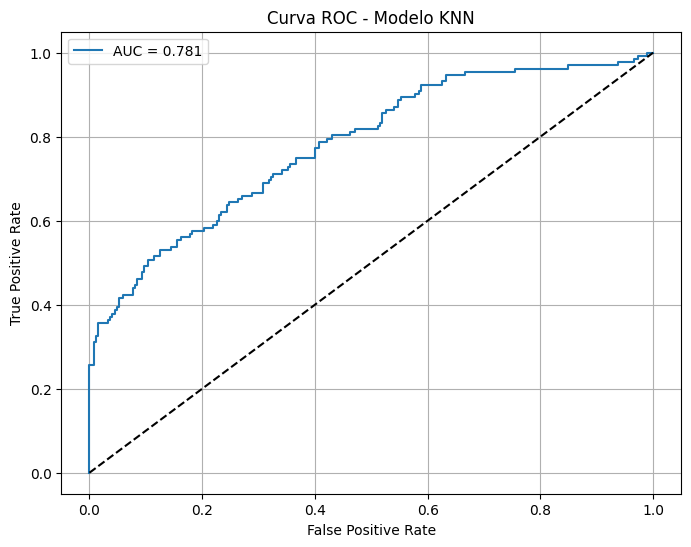

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Modelo KNN')
plt.legend()
plt.grid()
plt.show()

## Efecto de los hiperparámetros sobre la métrica ROC AUC

In [ ]:
resultados_svm = pd.DataFrame(grid_search.cv_results_)

In [ ]:
resultados_svm = resultados_svm.rename(columns={"mean_test_roc_auc": "ROC AUC"})

In [ ]:
resultados_svm["kernel"] = resultados_svm["param_kernel"].astype(str)
resultados_svm["gamma"] = resultados_svm["param_gamma"].astype(str)
resultados_svm["C"] = resultados_svm["param_C"].astype(str)
resultados_svm["degree"] = resultados_svm["param_degree"].astype(str)
resultados_svm["class_weight"] = resultados_svm["param_class_weight"].astype(str)

Influencia de tipo de kernel

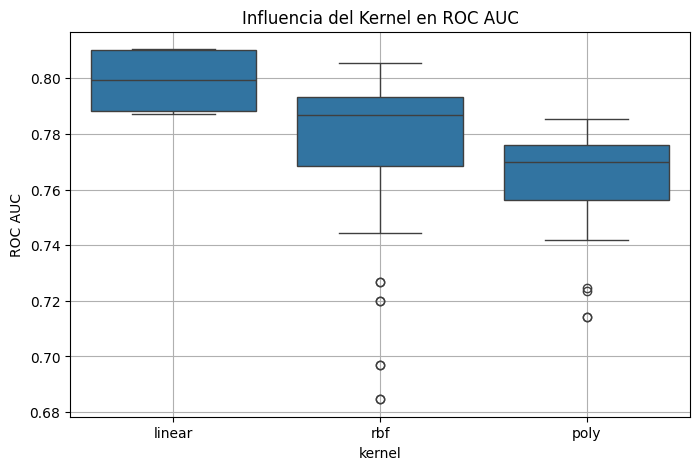

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=resultados_svm, x='kernel', y='ROC AUC')
plt.title('Influencia del Kernel en ROC AUC')
plt.grid(True)
plt.show()

Influencia del gamma

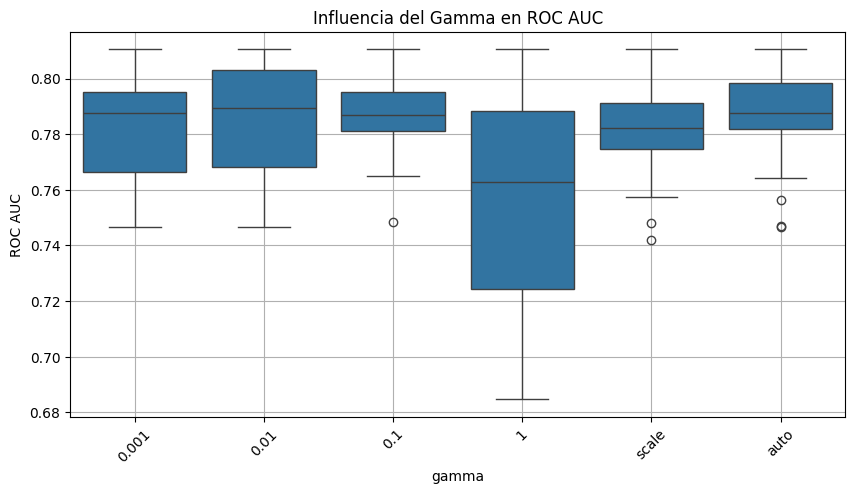

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=resultados_svm, x='gamma', y='ROC AUC')
plt.title('Influencia del Gamma en ROC AUC')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Influencia del C

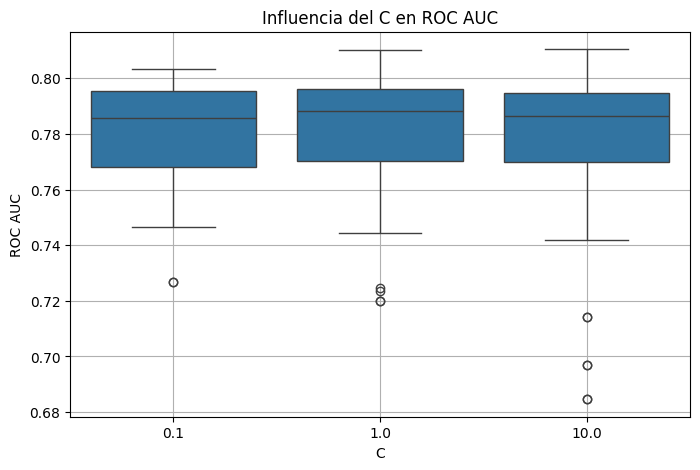

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=resultados_svm, x='C', y='ROC AUC')
plt.title('Influencia del C en ROC AUC')
plt.grid(True)
plt.show()

Influencia del grado para kernels polinomiales

In [ ]:
plt.figure(figsize=(6, 5))
sns.boxplot(data=resultados_svm, x='degree', y='ROC AUC')
plt.title('Influencia del Degree (solo poly) en ROC AUC')
plt.grid(True)
plt.show()

Influencia del Class weight

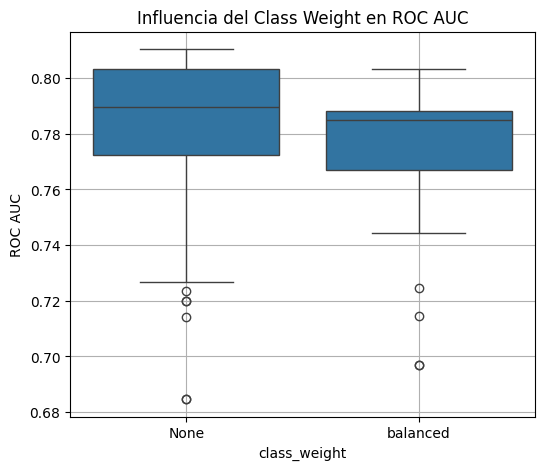

In [ ]:
plt.figure(figsize=(6, 5))
sns.boxplot(data=resultados_svm, x='class_weight', y='ROC AUC')
plt.title('Influencia del Class Weight en ROC AUC')
plt.grid(True)
plt.show()

Tabla con las mejores combinaciones

In [ ]:
cols = ['param_C', 'param_kernel', 'param_gamma', 'param_degree', 'param_class_weight', 'ROC AUC']
print("\nTop 10 combinaciones por ROC AUC:")
display(resultados_svm[cols].sort_values(by='ROC AUC', ascending=False).head(10))


Top 10 combinaciones por ROC AUC:


,param_C,param_kernel,param_gamma,param_degree,param_class_weight,ROC AUC
177,10.0,linear,auto,3,None,0.810483
156,10.0,linear,scale,2,None,0.810483
159,10.0,linear,auto,2,None,0.810483
162,10.0,linear,0.001,3,None,0.810483
165,10.0,linear,0.01,3,None,0.810483
150,10.0,linear,0.1,2,None,0.810483
147,10.0,linear,0.01,2,None,0.810483
144,10.0,linear,0.001,2,None,0.810483
153,10.0,linear,1,2,None,0.810483
174,10.0,linear,scale,3,None,0.810483
